In [1]:
%load_ext watermark
%watermark

2019-04-09T00:58:49-05:00

CPython 3.7.3rc1
IPython 7.3.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 8]
np.random.seed(42)

In [3]:
from sklearn.datasets import make_blobs

In [4]:
make_blobs?

In [5]:
K = 3
n_muestras = 5000

centroides = [(24, 30), (52, 35), (35, 60)]
X, clases_reales = make_blobs(n_samples = n_muestras, n_features = 2, cluster_std = 5.0,
                  centers = centroides, shuffle = False, random_state = 42)

In [6]:
X.shape

(5000, 2)

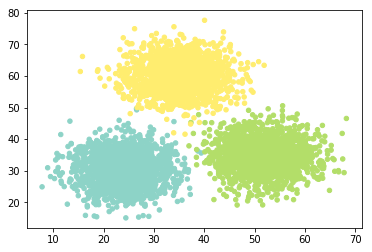

In [7]:
from matplotlib  import cm

plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap = cm.Set3);

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

In [9]:
estimador_kmedias = KMeans(n_clusters = 3)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

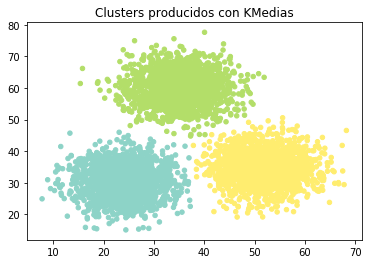

In [10]:
plt.scatter(X[:,0],X[:,1], c = etiquetas_kmedias,s = 20, marker = 'o', cmap = cm.Set3)
plt.title("Clusters producidos con KMedias");

Dado que en este ejemplo, tenemos las clases verdaderas (ya que hemos generado el dataset de forma artificial), vamos a hacer unas funciones auxiliares que nos ayuden a mostrar de forma clara aquellos puntos que se clasifican de forma incorrecta.

En primer lugar, creamos una función que nos calcule el Índice de Jaccard de dos grupos de puntos (definido como el número de elementos comunes a los dos grupos (intersección) de los dos grupos dividida por el número de elementos en cualquiera de los dos grupos (la unión).

In [11]:
def jaccard_index(cluster1, cluster2):
    intersection = np.intersect1d(cluster1, cluster2).shape[0]
    union = np.union1d(cluster1, cluster2).shape[0]
    return intersection / union

In [12]:
jaccard_index(X[clases_reales == 0], X[etiquetas_kmedias == 0])

0.9952095808383233

Ahora hacemos una funcion, que dado un conjunto de clases y clusters, nos diga que cluster se corresponde a cada clase. Esto es necesario ya que los nombres que da el estimador de clustering no tienen por qué coincidir con las clases reales (es decir, la clase `0` no tiene que representar al mismo número de puntos que el cluster `0`).

In [13]:
from itertools import product

In [14]:
list(product([1,2],[3,4]))

[(1, 3), (1, 4), (2, 3), (2, 4)]

In [15]:
def emparejar_clusters_clases(clusters, clases):
    combinaciones = product(np.unique(clases), np.unique(clusters))
    emparejamientos = {}
    class_ids = np.unique(clases)
    cluster_ids = np.unique(clusters)
    for cluster_id in cluster_ids:
        old_jaccard = 0
        for class_id in class_ids:
            new_jaccard = jaccard_index(X[clases == class_id], X[clusters == cluster_id])
            if new_jaccard > old_jaccard:
                old_jaccard = new_jaccard
                emparejamientos[cluster_id] = class_id
                if new_jaccard >= 0.5:
                    break
    return emparejamientos

In [16]:
emparejar_clusters_clases(etiquetas_kmedias, clases_reales)

{0: 0, 1: 2, 2: 1}

Con estas funciones podemos crear una función auxiliar que nos transforma unas etiquetas de cluster para que se correspondan con las clases reales, y una función que nos devuelva aquellas observaciones cuya clase no coincida con el cluster 

In [17]:
def alinear_clusters(clusters, clases):
    reemplazos = emparejar_clusters_clases(clusters, clases)
    clusters_alineados = [reemplazos[x] for x in clusters]
    return np.array(clusters_alineados)

def encontrar_errores(clusters, clases):
    etiquetas_clusters_alineadas = alinear_clusters(clusters, clases)
    return X[clases != etiquetas_clusters_alineadas]

Ahora podemos visualizar los puntos mal agrupados

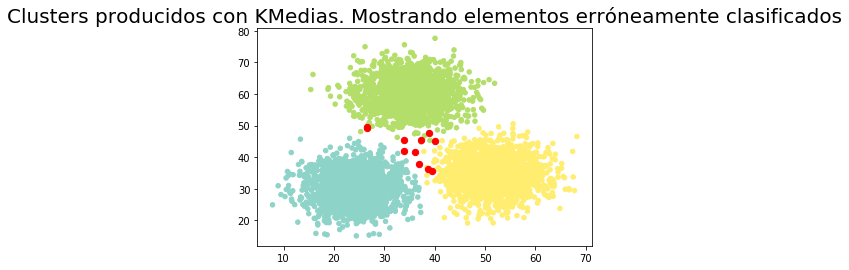

In [18]:
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c = etiquetas_kmedias,s = 20, marker = 'o', cmap = cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s = 40, marker = 'o', color = "red")

plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size = 20);

In [19]:
silhouette_score(X, etiquetas_kmedias)

0.6801855780824735

In [20]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias)

(0.9848477175260212, 0.9848485778151884, 0.984848147670417)

Ahora evaluamos con DBSCAN, es difícil comparar resultados con KMedias dado que en KMedias se especifica el número de clusters y en DBSCAN se especifica la densidad de los mismos

In [21]:
estimador_dbscan = DBSCAN(eps = 10, min_samples = 1000)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

In [22]:
np.unique(etiquetas_dbscan)

array([-1,  0,  1,  2], dtype=int64)

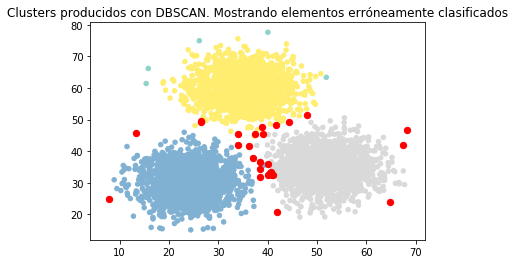

In [23]:
plt.scatter(X[:,0],X[:,1],c = etiquetas_dbscan,s = 20, marker = 'o', cmap = cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s = 40, marker = 'o', color = "red")

plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados");

In [24]:
silhouette_score(X, etiquetas_dbscan)

0.6723834492118366

In [25]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan)

(0.9720560210205188, 0.9604880908580997, 0.9662374339590347)

Vemos que para el caso de tres clusters claramente definidos, KMedias funciona ligeramente mejor que DBSCAN

Probamos ahora con una distribución de datos que no sean tan fáciles de separar en grupos basándose en criterios geométricos.

In [26]:
from sklearn.datasets import make_circles

la función `make_circles` como su nombre indica, genera un dataset bidimensional en la forma de dos círculos concéntricos

In [27]:
make_circles?

In [28]:
X, clases_reales = make_circles(n_samples = 5000, factor = 0.3, noise = 0.05)

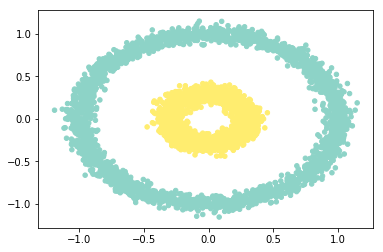

In [29]:
plt.scatter(X[:,0],X[:,1],c = clases_reales,s = 20, marker = 'o', cmap = cm.Set3);

In [30]:
estimador_kmedias = KMeans(n_clusters = 2)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

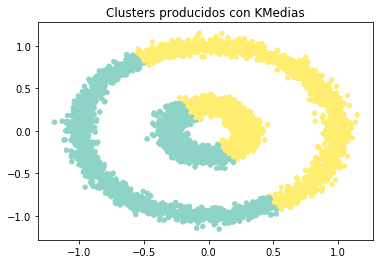

In [31]:
plt.scatter(X[:,0],X[:,1],c = etiquetas_kmedias,s = 20, marker = 'o', cmap = cm.Set3)
plt.title("Clusters producidos con KMedias");

Vemos que al basarse en el criterio de cercania al centroide, y dado que ambos clases tienen el mismo centroide, el algoritmo KMedias funciona de forma bastante mediocre, por no decir catastrófica.

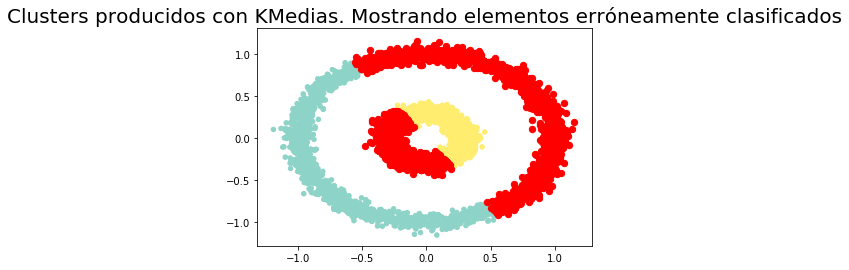

In [32]:
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c = etiquetas_kmedias,s = 20, marker = 'o', cmap = cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s = 40, marker = 'o', color = "red")

plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size=20);

Vemos que KMedias agrupa de forma incorrecta la mitad de los puntos

In [33]:
silhouette_score(X, etiquetas_kmedias)

0.2965402375734083

In [34]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias)

(7.804233496946991e-05, 7.805674993155743e-05, 7.80495417849392e-05)

Veamos ahora que tal funciona DBSCAN con este dataset

In [35]:
estimador_dbscan = DBSCAN(eps = 0.05, min_samples = 10)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

In [36]:
np.unique(etiquetas_dbscan)

array([-1,  0,  1], dtype=int64)

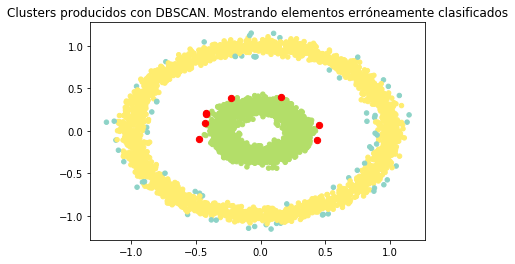

In [37]:
plt.scatter(X[:,0],X[:,1],c = etiquetas_dbscan,s = 20, marker = 'o', cmap = cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s = 40, marker = 'o', color = "red")

plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados");

Vemos que al basarse en un criterio de densidad, DBSCAN encuentra los clusters fácilmente.

In [38]:
silhouette_score(X, etiquetas_dbscan)

0.19928594442477718

In [39]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan)

(0.9925576876229771, 0.9021177335794555, 0.9451791917341158)

En este caso he obtenido los hiperparámetros `eps=0.05, min_samples=10` a ojo, iterando sobre el gráfico para ver que valores separaban correctamente las clases reales. En general haríamos una optimización de hiperparámetros para obtener los valores que mejor funcionen.

In [40]:
estimador_dbscan.predict

AttributeError: 'DBSCAN' object has no attribute 'predict'

Una desventaja del estimador DBSCAN en ´sklearn´ es que no tiene el método predict. Es decir, no puede asignar clusters a nuevos puntos sin tener que ajustar el estimador desde cero.

## HDBSCAN*

HDBSCAN\* es la version actualizada del algoritmo DBSCAN (el original es de 1996, la actualización se publicó en 2015). Está disponible como contribución de scikit-learn en el paquete `hdbscan`

In [42]:
pip install hdbscan

  Using cached https://files.pythonhosted.org/packages/22/8d/1fc4bfd17ae871441fd6440abc3da5fdecf34831aa711e3e52727ab00556/hdbscan-0.8.19.tar.gz
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Complete output from command c:\users\jorge\appdata\local\programs\python\python37\python.exe c:\users\jorge\appdata\local\programs\python\python37\lib\site-packages\pip\_vendor\pep517\_in_process.py build_wheel C:\Users\jorge\AppData\Local\Temp\tmph2jzwkpe:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\hdbscan_.py -> build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\plots.py -> build\lib.win-amd64-3.7\hdbscan
  co

  Failed building wheel for hdbscan
Could not build wheels for hdbscan which use PEP 517 and cannot be installed directly


In [56]:
import sys

#!conda install --yes --prefix {sys.prefix} -c conda-forge hdbscan

SyntaxError: invalid syntax (<ipython-input-56-bc3833117862>, line 2)

In [41]:
from hdbscan import HDBSCAN

ModuleNotFoundError: No module named 'hdbscan'

In [53]:
print(HDBSCAN.__doc__)

NameError: name 'HDBSCAN' is not defined

In [51]:
estimador_hdbscan = HDBSCAN()
etiquetas_hdbscan = estimador_hdbscan.fit_predict(X)

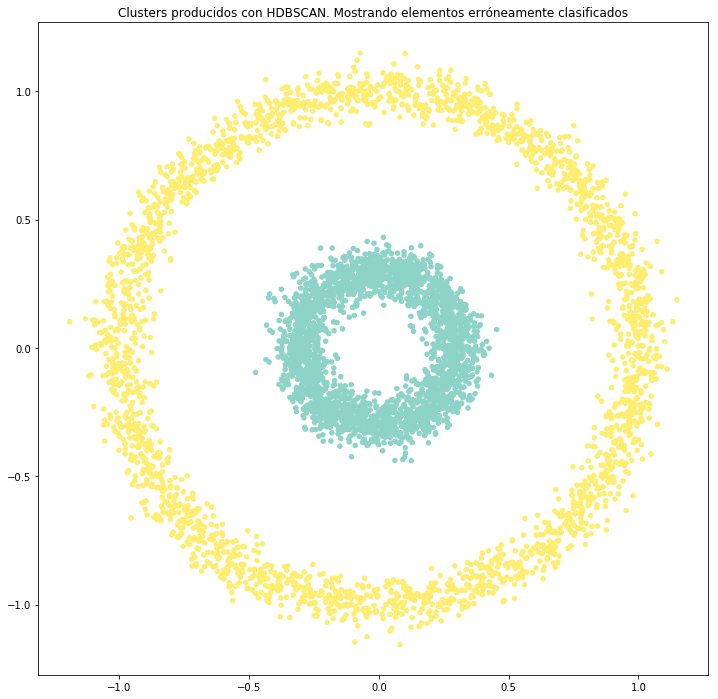

In [52]:
plt.scatter(X[:,0],X[:,1],c=etiquetas_hdbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_hdbscan = encontrar_errores(etiquetas_hdbscan, clases_reales)
plt.scatter(errores_hdbscan[:,0],errores_hdbscan[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con HDBSCAN. Mostrando elementos erróneamente clasificados");

Vemos que HDBSCAN agrupa de forma perfecta las dos clases

Al contrario que DBSCAN, la implementacion de `hdbscan` tiene un metodo `approximate_predict` que una vez ajustado permite asignar clusters a nuevos puntos sin tener que realizar todo el proceso desde cero.